In [21]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp
from scipy import stats
import pandas as pd

# Help Functions

In [103]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [127]:
def plot_approx_and_exact(h, t_num, X_num, t_anal, X_anal, method="Euler", saveasfile=None):
    #plt.title(method+" method with stepsize $2^{"+f"{np.log2(h)}"+"}$")
    plt.plot(t_num, X_num, label="Numerical", linewidth=1)
    plt.plot(t_fine, X_anal, label="Analytic", linewidth=0.5 )
    plt.xlabel("time $t$")
    plt.ylabel("$X_t$")
    plt.subplots_adjust(bottom=0.15, left=0.15, top=0.95)
    plt.grid()
    plt.legend()
    if saveasfile!=None:
        plt.savefig("Figures/"+saveasfile)
    plt.show()

In [23]:
def print_error_estimates(hs, error_estimates_vec):
    print("Stepsize".ljust(19), end="")
    for h in hs:
        print("|{h:.2e}".format(h=h).ljust(11),end="")
    print()

    for error_estimates in error_estimates_vec:
        print("Approx Abs Error".ljust(19), end="")
        for error_estimate in error_estimates:
            print("|{error_estimate:.3f}".format(error_estimate=error_estimate).ljust(11),end="",)
        print()

In [24]:
def estimated_mean_variance_depsilon(error_estimates_batch, alpha=0.1):
    M=len(error_estimates_batch)
    mean = np.mean(error_estimates_batch)
    var = 1/(M-1) * np.sum((error_estimates_batch-mean)**2)
    depsilon = stats.t.ppf(1-alpha/2, df=M-1, loc=0, scale=1)*np.sqrt(var/M)
    return mean, var, depsilon

In [25]:
def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

In [129]:
def conf_intervals_Ms(arguments, method, N, Ms, h, plot=True):
    M = max(Ms)
    error_estimates_batches = np.zeros(M)
    for i in range(M):
        error_estimates_batches[i] = error_approximation(method, N, h, arguments)
    
    
    means = np.zeros(len(Ms))
    depsilons = np.zeros(len(Ms))
    for i in range(len(Ms)):
        means[i], _, depsilons[i] = estimated_mean_variance_depsilon(error_estimates_batches[:Ms[i]])

    fig, ax = plt.subplots()
    ax.errorbar(Ms, means, depsilons, fmt='o', linewidth=2, capsize=6)
    plt.show()

    return Ms, means, depsilons

In [130]:
def conf_intervals_hs(arguments, method, method_string, N, M, hs, plot=True, saveasfile=None):

    error_estimates_batches = [[error_approximation(method, N, h, arguments) for i in range(M)] for h in hs ] #One row is one h

    means = np.zeros(len(hs))
    depsilons = np.zeros(len(hs))
    for i in range(len(hs)):
        means[i], _, depsilons[i] = estimated_mean_variance_depsilon(np.array(error_estimates_batches[i]))

    fig, ax = plt.subplots()
    res = stats.linregress(np.log2(hs[2:]), np.log2(means[2:]))
    convergence_order = 0.5*round(res.slope/0.5)
    print(f"Numerical convergence rate: {signif(res.slope,3)}")
    ax.plot(hs, 2**(res.intercept + convergence_order*np.log2(hs)),label="$h^{"+str(convergence_order)+"}$",linestyle="--", 
            color="orange", linewidth=3.5)
    
    #ax.set_title("Convergence plot for "+method_string)
    ax.errorbar(hs, means, depsilons, fmt='o', color="b", linewidth=2, capsize=6, markersize=1)
    ax.plot(hs, means, linewidth=0.5, color="b", label="$\hat{\epsilon}$")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_xlabel("stepsize")
    ax.set_ylabel("Expected Absolute Error")
    plt.gca().invert_xaxis()
    
    plt.subplots_adjust(bottom=0.15, left=0.15, top=0.95)
    plt.legend()
    plt.grid()

    if saveasfile!=None:
        plt.savefig("Figures/"+saveasfile)
    plt.show()

# Text

Let $\{X_t|t\in \mathbb{R}^+\}$ be a one-dimensional Ito process defined by  
$$
dX_t = a(t,X_t)dt + b(t,X_t)dB_t,
$$
where $B_t$ is the one-dimensional Brownian motion.
Let $Y^{\delta}(t)$ be a numerical approximation of $X_t$ with maximum stepsize $\delta$. Define the absolute error criterion
$$
\epsilon = E(|X_T -Y(T)|).
$$
A time discrete approximation $Y^\delta$ is said to converge strongly at time $T$ of order $\gamma$ if $\exists\; C>0$ independent of $\delta$ and $\delta_0$ s.t. 
$$
\epsilon(\delta) = E(|X_T -Y^{\delta}(T)|)\leq C\delta^{\gamma}
$$
for each $\delta\in(0,\delta_0)$. Note that if one removes the diffusion coefficient, this reduces to the deterministic convergence criterion.  

We will mainly focus on the test problem
\begin{equation}
\begin{cases}
dX_t = 1.5 X_t \, dt + X_t \,dB_t \\
X_0 =1 
\end{cases}
\end{equation}


This problem has the solution
$$
X_{t_n} = e^{(t_n + \sum_{i=1}^{n}\Delta B_{i-1} )}
$$
with the initial value
$$
X_0 =1
$$
Then the Euler scheme has the form
$$
Y_{n+1} = Y_n + a\Delta t_n + b \Delta B_n
$$

The Milstein scheme has the form
$$
Y_{n+1} = Y_n + a\Delta t_n + b\Delta B_n + \frac{1}{2}b\frac{\partial b}{\partial x}\left[ (\Delta B_n)^2 - \Delta t_n \right]
$$

# Euler Method

## The Method and Error Approximation function

In [26]:
def euler(h, X_0, a_func, b_func, a, b, f_anal):
    #Defining a fine resolution for analytic solution
    fineness = int(np.ceil(300*h))
    t_fine = np.arange(0,1+h/(2*fineness),h/fineness)
    dWs_fine = np.random.normal(loc=0, scale=np.sqrt(h/fineness), size=t_fine.shape)

    #Defining a course resolution for doing Eulers method
    t = t_fine[0::fineness]
    dWs = np.array([np.sum(dWs_fine[fineness*i:fineness*(i+1)]) for i in range(len(t))])
    
    #Solve analytic version
    X_anal = np.zeros(t_fine.shape)
    X_anal[0] = X_0
    W=0
    for i in range(1,len(t_fine)):
       W+=dWs_fine[i-1]
       X_anal[i] = f_anal(t_fine[i],W,X_0,a,b)

    #Eulers method for numerical solution
    X = np.zeros(t.shape)
    X[0]=X_0
    for i in range(len(t)-1):
        X[i+1] = X[i] + a_func(t[i],X[i],a)*h + b_func(t[i],X[i],b)*dWs[i]

    return t, X, t_fine, X_anal

In [27]:
def milstein(h, X_0, a_func, b_func, b_derivative, a, b, f_anal):
    #Defining a fine resolution for analytic solution
    fineness = int(np.ceil(300*h))
    t_fine = np.arange(0,1+h/(2*fineness),h/fineness)
    dWs_fine = np.random.normal(loc=0, scale=np.sqrt(h/fineness), size=t_fine.shape)

    #Defining a course resolution for doing Milsteins method
    t = t_fine[0::fineness]
    dWs = np.array([np.sum(dWs_fine[fineness*i:fineness*(i+1)]) for i in range(len(t))])
    
    #Solve analytic version
    X_anal = np.zeros(t_fine.shape)
    X_anal[0] = X_0
    W=0
    for i in range(1,len(t_fine)):
       W+=dWs_fine[i-1]
       X_anal[i] = f_anal(t_fine[i],W,X_0,a,b)

    #Milsteins method for numerical solution
    X = np.zeros(t.shape)
    X[0]=X_0
    for i in range(len(t)-1):
        X[i+1] = X[i] + a_func(t[i],X[i],a)*h + b_func(t[i],X[i],b)*dWs[i] + 0.5*b_func(t[i],X[i],b)*b_derivative(t[i],X[i],b) *(dWs[i]**2-h )

    return t, X, t_fine, X_anal

In [28]:
def error_approximation(method, N, h, arguments):
    
    path_errors = np.zeros(N)
    for i in range(N):
        _, X_num, _, X_anal = method(h,**arguments)
        path_errors[i] = np.abs(X_anal[-1]-X_num[-1])

    return np.mean(np.abs(path_errors))


## Test Problems

In [31]:
def f_1(t, W, X_0, a, b):
    return X_0*exp( (a-0.5*b**2)*t+ b*W )

def a_func_1(t, X_t, a):
    return a*X_t
def b_func_1(t, X_t, b):
    return b*X_t
def b_func_derivative_1(t, X_t, b):
    return b+0*X_t

### Simulating Simple Paths

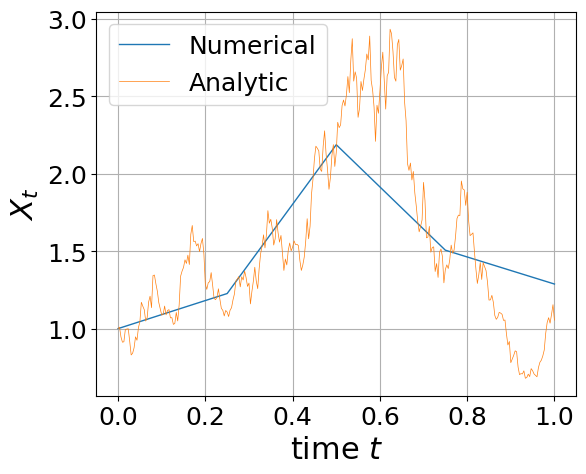

In [131]:
np.random.seed(153)

h=2**-2
arguments={ "X_0":1, "a":1.5, "b":1,"a_func":a_func_1, "b_func":b_func_1, "f_anal":f_1}
t_num, X_num, t_fine, X_anal = euler(h, **arguments)

plot_approx_and_exact(h, t_num, X_num, t_fine, X_anal,saveasfile="euler_coarse.pdf")

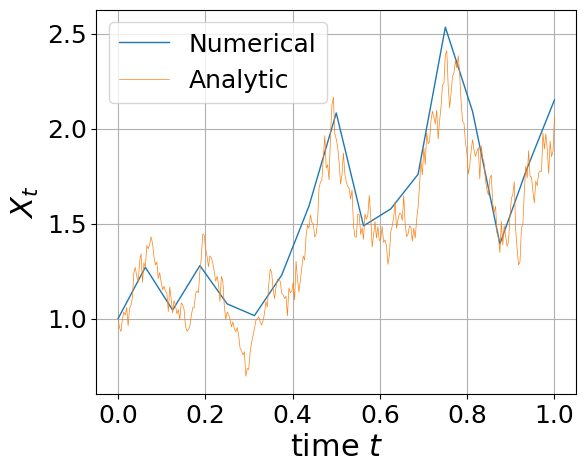

In [132]:
np.random.seed(218)

h=2**-4
arguments={ "X_0":1, "a":1.5, "b":1,"a_func":a_func_1, "b_func":b_func_1, "f_anal":f_1}
t_num, X_num, t_fine, X_anal = euler(h, **arguments)

plot_approx_and_exact(h, t_num, X_num, t_fine, X_anal, saveasfile="euler_fine.pdf")

### Simulate to Approximate Absolute Error Criterion

In [34]:
np.random.seed(155)

hs = [2**-4, 2**-5, 2**-6, 2**-7]
arguments={ "X_0":1, "a":1.5, "b":0.1,"a_func":a_func_1, "b_func":b_func_1, "f_anal":f_1}
error_estimates_1 = [error_approximation(euler, 25, h, arguments) for h in hs]

print_error_estimates(hs, [error_estimates_1])

Stepsize           |6.25e-02  |3.12e-02  |1.56e-02  |7.81e-03  
Approx Abs Error   |0.292     |0.154     |0.074     |0.035     


In [35]:
np.random.seed(219)

hs = [2**-4, 2**-5, 2**-6, 2**-7]
arguments={ "X_0":1, "a":1.5, "b":0.1,"a_func":a_func_1, "b_func":b_func_1, "f_anal":f_1}
error_estimates_2 = [error_approximation(euler, 25, h, arguments) for h in hs]

print_error_estimates(hs,[error_estimates_1,error_estimates_2])

Stepsize           |6.25e-02  |3.12e-02  |1.56e-02  |7.81e-03  
Approx Abs Error   |0.292     |0.154     |0.074     |0.035     
Approx Abs Error   |0.306     |0.136     |0.074     |0.036     


### Estimate $90\%$ confidence interval

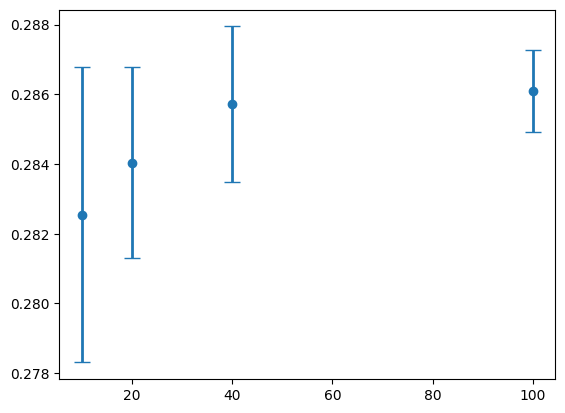

([10, 20, 40, 100],
 array([0.282548  , 0.28404244, 0.28571329, 0.28609699]),
 array([0.00424096, 0.00272732, 0.00223294, 0.00118676]))

In [36]:
np.random.seed(219)
Ms = [10,20,40,100]
arguments={ "X_0":1, "a":1.5, "b":0.1,"a_func":a_func_1, "b_func":b_func_1, "f_anal":f_1}

conf_intervals_Ms( arguments, euler, 100, Ms, 2**-4)

Numerical convergence rate: 0.499


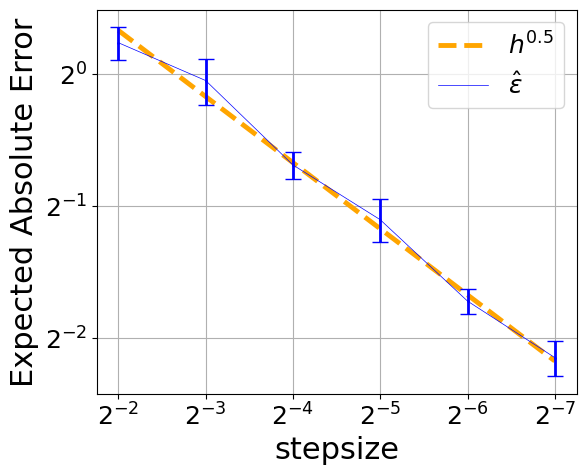

In [133]:
np.random.seed(219)
hs = [2**-2,2**-3,2**-4, 2**-5, 2**-6, 2**-7]
arguments={ "X_0":1, "a":1.5, "b":1,"a_func":a_func_1, "b_func":b_func_1, "f_anal":f_1}

conf_intervals_hs( arguments, euler, "Euler", N=100, M=20, hs=hs, saveasfile="euler_convergence.pdf")

# Milstein

## Simulating Simple Paths

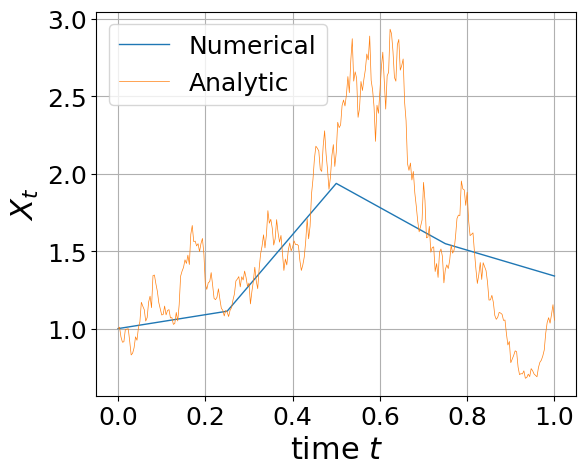

In [134]:
np.random.seed(153)


h= 2**-2
arguments={ "X_0":1, "a":1.5, "b":1,"a_func":a_func_1, "b_func":b_func_1, "b_derivative":b_func_derivative_1, "f_anal":f_1}
t_num, X_num, t_fine, X_anal = milstein(h, **arguments)

plot_approx_and_exact(h, t_num, X_num, t_fine, X_anal, method="Milstein", saveasfile="milstein_coarse.pdf")

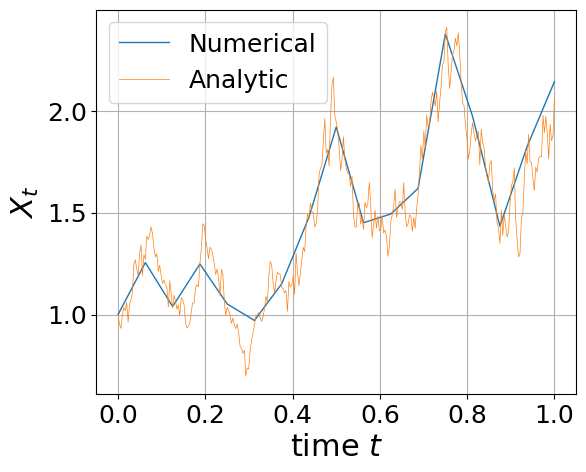

In [135]:
np.random.seed(218)

h= 2**-4
arguments={ "X_0":1, "a":1.5, "b":1,"a_func":a_func_1, "b_func":b_func_1, "b_derivative":b_func_derivative_1, "f_anal":f_1}
t_num, X_num, t_fine, X_anal = milstein(h, **arguments)

plot_approx_and_exact(h, t_num, X_num, t_fine, X_anal,"Milstein",saveasfile="milstein_fine.pdf")

## Confidence intervals

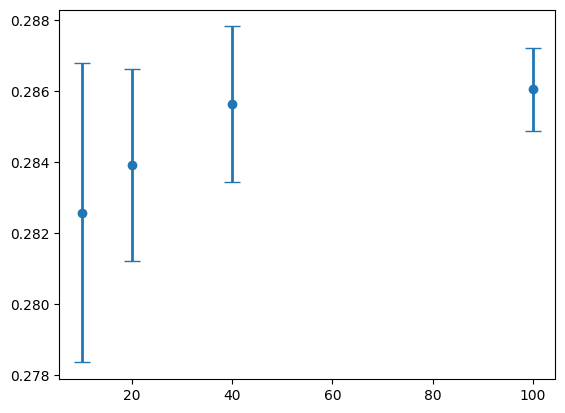

([10, 20, 40, 100],
 array([0.28257272, 0.28392172, 0.28562583, 0.28605144]),
 array([0.00421506, 0.00270795, 0.00219418, 0.00117366]))

In [40]:
np.random.seed(219)
Ms = [10,20,40,100]
arguments={ "X_0":1, "a":1.5, "b":0.1,"a_func":a_func_1, "b_func":b_func_1,"b_derivative":b_func_derivative_1, "f_anal":f_1}

conf_intervals_Ms( arguments, milstein, 100, Ms, 2**-4)

Numerical convergence rate: 0.939


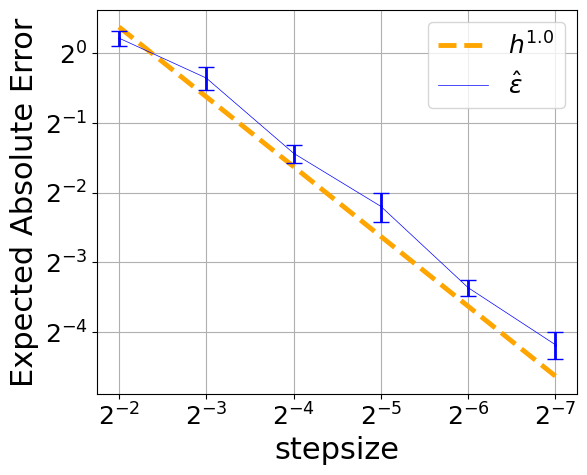

In [136]:
np.random.seed(219)
hs = [2**-2,2**-3,2**-4, 2**-5, 2**-6, 2**-7]
arguments={ "X_0":1, "a":1.5, "b":1,"a_func":a_func_1, "b_func":b_func_1, "b_derivative":b_func_derivative_1, "f_anal":f_1}

conf_intervals_hs( arguments, milstein, "Milstein",N=100, M=20, hs=hs, saveasfile="milstein_convergence.pdf")